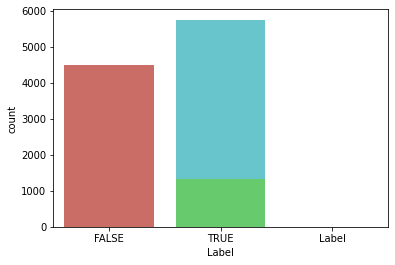

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  4 12:00:49 2017

@author: NishitP
"""
#import os

import pandas as pd
import csv
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from sklearn import svm
#before reading the files, setup the working directory to point to project repo
#reading data files 


test_filename = 'test.csv'
train_filename = 'train.csv'
valid_filename = 'valid.csv'

train_news = pd.read_csv(train_filename)
test_news = pd.read_csv(test_filename)
valid_news = pd.read_csv(valid_filename)



#data observation
def data_obs():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(10))

    #below dataset were used for testing and validation purposes
    print(test_news.shape)
    print(test_news.head(10))
    
    print(valid_news.shape)
    print(valid_news.head(10))

#check the data by calling below function
#data_obs()

#distribution of classes for prediction
def create_distribution(dataFile):
    
    return sb.countplot(x='Label', data=dataFile, palette='hls')
    

#by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_news)
create_distribution(test_news)
create_distribution(valid_news)


#data integrity check (missing label values)
#none of the datasets contains missing values therefore no cleaning required
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train_news.isnull().sum()
    train_news.info()
        
    print("check finished.")

    #below datasets were used to 
    test_news.isnull().sum()
    test_news.info()

    valid_news.isnull().sum()
    valid_news.info()

#run the below function call to see the quality check results
#data_qualityCheck()



#eng_stemmer = SnowballStemmer('english')
#stopwords = set(nltk.corpus.stopwords.words('english'))

#Stemming
def stem_tokens(tokens, stemmer):
    stemmed = []
    for token in tokens:
        stemmed.append(stemmer.stem(token))
    return stemmed

#process the data
def process_data(data,exclude_stopword=True,stem=True):
    tokens = [w.lower() for w in data]
    tokens_stemmed = tokens
    tokens_stemmed = stem_tokens(tokens, eng_stemmer)
    tokens_stemmed = [w for w in tokens_stemmed if w not in stopwords ]
    return tokens_stemmed


#creating ngrams
#unigram 
def create_unigram(words):
    assert type(words) == list
    return words

#bigram
def create_bigrams(words):
    assert type(words) == list
    skip = 0
    join_str = " "
    Len = len(words)
    if Len > 1:
        lst = []
        for i in range(Len-1):
            for k in range(1,skip+2):
                if i+k < Len:
                    lst.append(join_str.join([words[i],words[i+k]]))
    else:
        #set it as unigram
        lst = create_unigram(words)
    return lst



porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]




In [7]:
countV = CountVectorizer()
train_count = countV.fit_transform(train_news['Statement'].values)

print(countV)
print(train_count)

#print training doc term matrix
#we have matrix of size of (10240, 12196) by calling below
def get_countVectorizer_stats():
    
    #vocab size
    train_count.shape

    #check vocabulary using below command
    print(countV.vocabulary_)

    #get feature names
    print(countV.get_feature_names()[:25])


#create tf-df frequency features
#tf-idf 
tfidfV = TfidfTransformer()
train_tfidf = tfidfV.fit_transform(train_count)

def get_tfidf_stats():
    train_tfidf.shape
    #get train data feature names 
    print(train_tfidf.A[:10])


#bag of words - with n-grams
#countV_ngram = CountVectorizer(ngram_range=(1,3),stop_words='english')
#tfidf_ngram  = TfidfTransformer(use_idf=True,smooth_idf=True)

tfidf_ngram = TfidfVectorizer(stop_words='english',ngram_range=(1,4),use_idf=True,smooth_idf=True)


#POS Tagging
tagged_sentences = nltk.corpus.treebank.tagged_sents()

cutoff = int(.75 * len(tagged_sentences))
training_sentences = train_news['Statement']
 
print(training_sentences)

#training POS tagger based on words
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }
    
    
#helper function to strip tags from tagged corpus	
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]



#Using Word2Vec 
filepath = "C:\Users\jake\Documents\GitHub\Vectorizer"
with open('Vectorizer/glove.6B.50d.txt', "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}



#model = gensim.models.Word2Vec(X, size=100) # x be tokenized text
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])



CountVectorizer()
  (0, 9676)	1
  (0, 10988)	1
  (0, 1044)	1
  (0, 6639)	1
  (0, 8376)	1
  (0, 5115)	1
  (0, 10709)	1
  (0, 11036)	1
  (0, 11296)	1
  (0, 615)	1
  (0, 7728)	1
  (0, 3278)	1
  (1, 10988)	1
  (1, 11934)	2
  (1, 3434)	1
  (1, 3185)	1
  (1, 7672)	1
  (1, 2475)	1
  (1, 10425)	1
  (1, 6052)	1
  (1, 10426)	2
  (1, 7418)	1
  (1, 4860)	1
  (1, 11138)	1
  (1, 7674)	1
  :	:
  (10239, 10988)	1
  (10239, 7672)	2
  (10239, 11110)	2
  (10239, 5267)	1
  (10239, 7828)	1
  (10239, 7824)	1
  (10239, 1159)	1
  (10239, 12151)	2
  (10239, 6327)	1
  (10239, 6603)	1
  (10239, 11013)	1
  (10239, 11004)	1
  (10239, 3309)	1
  (10239, 12158)	1
  (10239, 11660)	2
  (10239, 799)	1
  (10239, 2568)	1
  (10239, 11622)	1
  (10239, 2549)	1
  (10239, 10660)	1
  (10239, 8996)	1
  (10239, 10918)	1
  (10239, 3989)	1
  (10239, 10594)	1
  (10239, 6853)	1
0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with Joh

FileNotFoundError: [Errno 2] No such file or directory: 'Vectorizer/glove.6B.50d.txt'

In [ ]:
svm_pipeline_ngram = Pipeline([
        ('svm_tfidf',tfidf_ngram),
        ('svm_clf',svm.LinearSVC())
        ])

svm_pipeline_ngram.fit(train_news['Statement'],train_news['Label'])
predicted_svm_ngram = svm_pipeline_ngram.predict(test_news['Statement'])
np.mean(predicted_svm_ngram == test_news['Label'])


0.6170129361034888